<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import cv2

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\stft"
# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

# Add padding and resize to 224x224x3 for Vision Transformer input
for i in range(len(eeg_folds)):
    padded_images = []
    for img in eeg_folds[i]:
        padded_img = cv2.copyMakeBorder(img, 16, 16, 16, 16, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        resized_img = cv2.resize(padded_img, (224, 224))
        padded_images.append(resized_img)
    eeg_folds[i] = np.array(padded_images, dtype=np.float16)

print(type(eeg_fold_4))
for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)
    
print(eeg_folds[1].shape)

<class 'numpy.ndarray'>
(1420, 224, 224, 3)


<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [6]:
import torch
import torch.nn as nn

debug_mode_flag = False
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set random seed for reproducibility
torch.manual_seed(42)
debug_mode_flag = False


def patchify(data, n_patches):
    n, c, h, w = data.shape
    # Create tensor on the same device as input data
    patches = torch.zeros(n, n_patches**2, (c*h*w) // (n_patches**2), device=data.device)
    patch_size = h // n_patches
    for idx, d in enumerate(data):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = d[:, i*patch_size: (i+1)*patch_size, j*patch_size: (j+1) * patch_size]
                patches[idx, i*n_patches + j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length, d, device='cpu'):
    result = torch.ones(sequence_length, d, device=device)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
class vit(nn.Module):
    def __init__(self, input_size, n_patches, hidden_size, num_classes, num_transformer_blocks=2, num_heads=4):
        super().__init__()
        self.chw = input_size
        self.n_patches = n_patches
        self.patch_size = ((self.chw[1] // n_patches) ** 2) * self.chw[0]
        
        # Core components
        self.linear_mapper = nn.Linear(self.patch_size, hidden_size)
        self.class_token = nn.Parameter(torch.rand(1, hidden_size))
        
        # Simplified positional embedding
        self.register_buffer('pos_embed', get_positional_embeddings(self.n_patches ** 2 + 1, hidden_size))
        
        # Normalization and Transformer
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True),
            num_layers=num_transformer_blocks
        )
        
        # Classification head
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Create patches
        patches = patchify(x, self.n_patches)
        
        # Project patches to embedding dimension
        x = self.linear_mapper(patches)
        
        # Add class token
        batch_size = x.shape[0]
        cls_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embeddings
        x = x + self.pos_embed
        x = self.layer_norm(x)
        
        # Apply transformer
        x = self.transformer(x)
        
        # Classification based on CLS token
        x = x[:, 0]
        return self.classifier(x)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [7]:

randomdata = torch.randn((1, 3, 224, 224))  # Adjusted to match the input shape (batch_size, channels, height, width)

# Modify the vit parameters to accommodate the shape mismatch
model = vit(input_size=(3, 224, 224), n_patches=14, hidden_size=256, num_classes=3)  # Adjusted n_patches and hidden_size
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [8]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                            Param #
vit                                                               256
├─Linear: 1-1                                                     196,864
├─LayerNorm: 1-2                                                  512
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          1,315,072
│    │    └─TransformerEncoderLayer: 3-2                          1,315,072
├─Linear: 1-4                                                     771
Total params: 2,828,547
Trainable params: 2,828,547
Non-trainable params: 0

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

Running experiment with parameters: {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 0.0001672579468577945, 'weight_decay': 1.8129496285151885e-05, 'num_transformer_blocks': 6, 'num_heads': 4}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
Epoch [1/100], Loss: 1.1133, Accuracy: 0.3358
Validation Loss: 1.1520, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.0899, Accuracy: 0.4054
Validation Loss: 1.1659, Validation Accuracy: 0.3577
Epoch [3/100], Loss: 1.0473, Accuracy: 0.4992
Validation Loss: 1.0830, Validation Accuracy: 0.4854
Epoch [4/100], Loss: 1.0274, Accuracy: 0.5327
Validation Loss: 1.0773, Validation Accuracy: 0.5112
Epoch [5/100], Loss: 1.0143, Accuracy: 0.5821
Validation Loss: 1.0695, Validation Accuracy: 0.5192
Epoch [6/100], Loss: 1.0005, Accuracy: 0.58

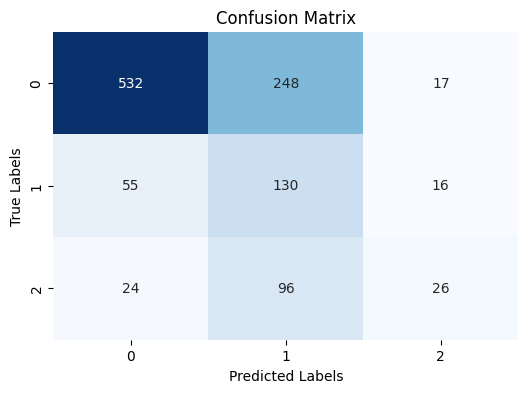


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 532/797 (66.75%)
Class 1: Correct Predictions / Total True Samples = 130/201 (64.68%)
Class 2: Correct Predictions / Total True Samples = 26/146 (17.81%)

Precision-Recall Curves:


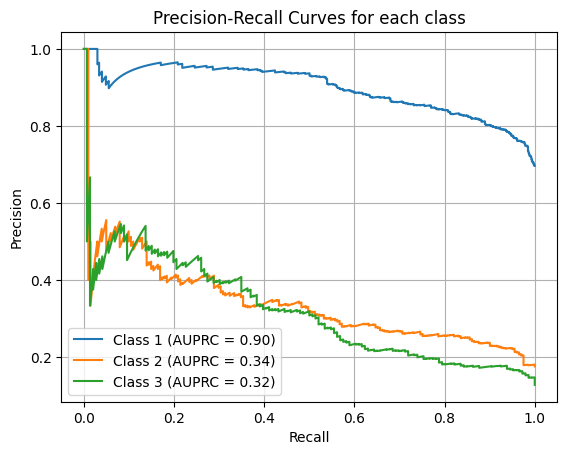


ROC Curves:


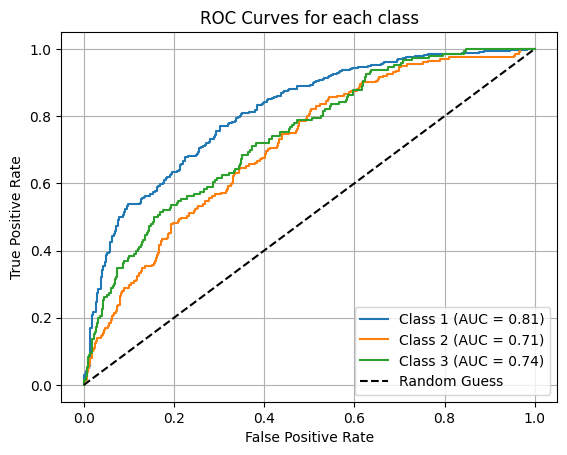


Mean F1 Score: 0.4648
Balanced Accuracy: 0.4975
Average AUPRC: 0.5170

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76       797
           1       0.27      0.65      0.39       201
           2       0.44      0.18      0.25       146

    accuracy                           0.60      1144
   macro avg       0.53      0.50      0.46      1144
weighted avg       0.71      0.60      0.63      1144

Fold No: 2
Epoch [1/100], Loss: 1.1151, Accuracy: 0.3368
Validation Loss: 1.0535, Validation Accuracy: 0.3325
Epoch [2/100], Loss: 1.1068, Accuracy: 0.3472
Validation Loss: 1.1438, Validation Accuracy: 0.3342
Epoch [3/100], Loss: 1.1019, Accuracy: 0.3731
Validation Loss: 1.1275, Validation Accuracy: 0.3978
Epoch [4/100], Loss: 1.0699, Accuracy: 0.4620
Validation Loss: 0.9825, Validation Accuracy: 0.5035
Epoch [5/100], Loss: 1.0476, Accuracy: 0.4732
Validation Loss: 1.0044, Validation Accuracy: 0.5324
Epoch [6/100], Los

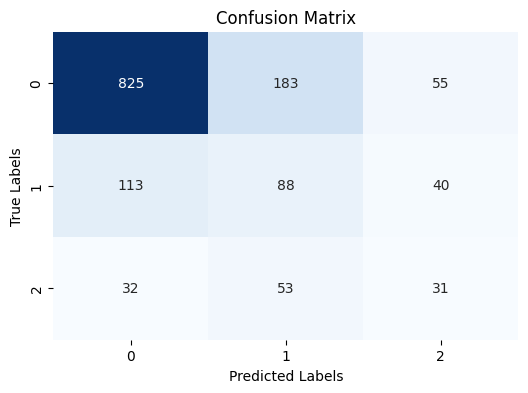


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 825/1063 (77.61%)
Class 1: Correct Predictions / Total True Samples = 88/241 (36.51%)
Class 2: Correct Predictions / Total True Samples = 31/116 (26.72%)

Precision-Recall Curves:


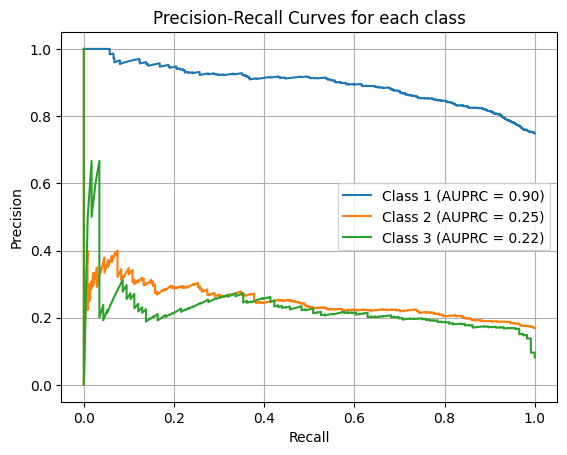


ROC Curves:


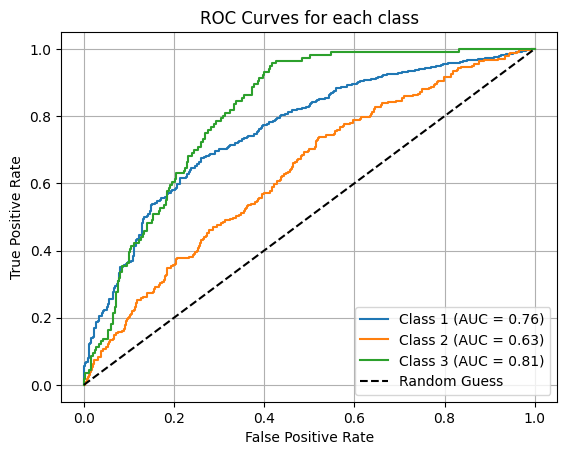


Mean F1 Score: 0.4598
Balanced Accuracy: 0.4695
Average AUPRC: 0.4558

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1063
           1       0.27      0.37      0.31       241
           2       0.25      0.27      0.26       116

    accuracy                           0.66      1420
   macro avg       0.46      0.47      0.46      1420
weighted avg       0.70      0.66      0.68      1420

Fold No: 3
Epoch [1/100], Loss: 1.1212, Accuracy: 0.3294
Validation Loss: 1.1996, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1076, Accuracy: 0.3392
Validation Loss: 1.1119, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1037, Accuracy: 0.3372
Validation Loss: 1.1500, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1054, Accuracy: 0.3470
Validation Loss: 1.2032, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1063, Accuracy: 0.3177
Validation Loss: 1.1050, Validation Accuracy: 0.3333
Epoch [6/100], Los

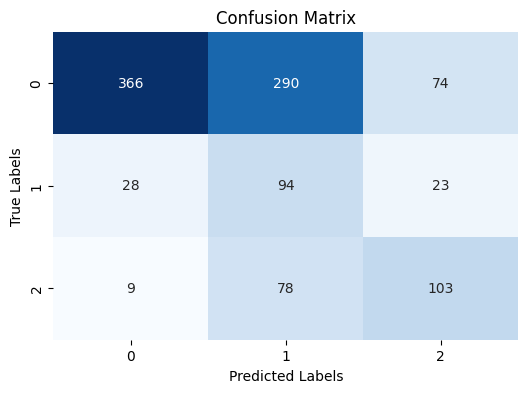


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 366/730 (50.14%)
Class 1: Correct Predictions / Total True Samples = 94/145 (64.83%)
Class 2: Correct Predictions / Total True Samples = 103/190 (54.21%)

Precision-Recall Curves:


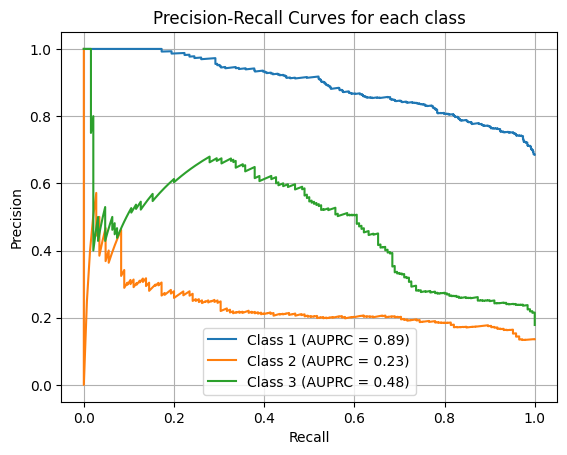


ROC Curves:


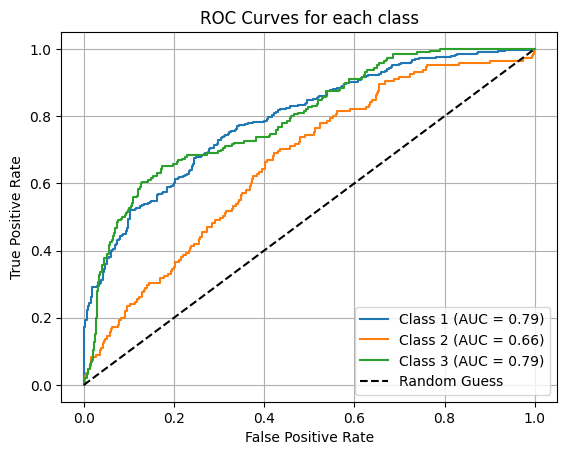


Mean F1 Score: 0.4947
Balanced Accuracy: 0.5639
Average AUPRC: 0.5329

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.50      0.65       730
           1       0.20      0.65      0.31       145
           2       0.52      0.54      0.53       190

    accuracy                           0.53      1065
   macro avg       0.54      0.56      0.49      1065
weighted avg       0.74      0.53      0.58      1065

Fold No: 4
Epoch [1/100], Loss: 1.1244, Accuracy: 0.3288
Validation Loss: 1.2485, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1080, Accuracy: 0.3215
Validation Loss: 1.1066, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1116, Accuracy: 0.3370
Validation Loss: 1.0152, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1066, Accuracy: 0.3270
Validation Loss: 1.1082, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1034, Accuracy: 0.3361
Validation Loss: 1.0677, Validation Accuracy: 0.3333
Epoch [6/100], Los

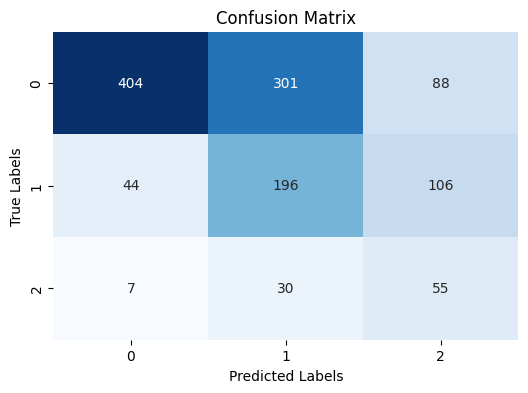


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 404/793 (50.95%)
Class 1: Correct Predictions / Total True Samples = 196/346 (56.65%)
Class 2: Correct Predictions / Total True Samples = 55/92 (59.78%)

Precision-Recall Curves:


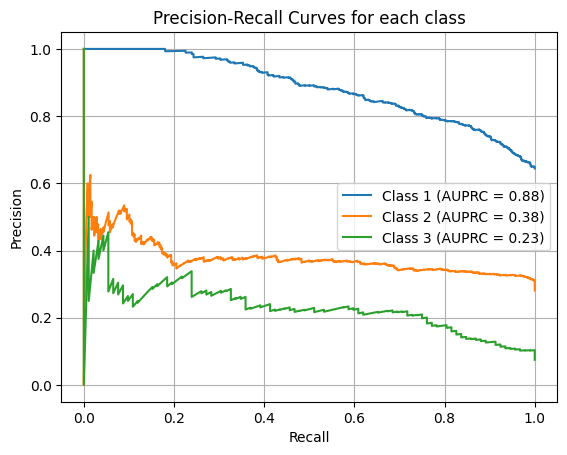


ROC Curves:


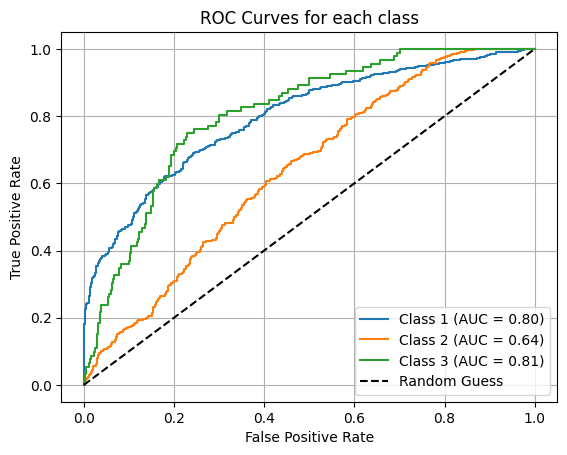


Mean F1 Score: 0.4730
Balanced Accuracy: 0.5579
Average AUPRC: 0.4953

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.51      0.65       793
           1       0.37      0.57      0.45       346
           2       0.22      0.60      0.32        92

    accuracy                           0.53      1231
   macro avg       0.49      0.56      0.47      1231
weighted avg       0.69      0.53      0.57      1231

Fold No: 5
Epoch [1/100], Loss: 1.1247, Accuracy: 0.3215
Validation Loss: 1.1400, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1065, Accuracy: 0.3429
Validation Loss: 1.1277, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.0988, Accuracy: 0.3584
Validation Loss: 1.1588, Validation Accuracy: 0.3997
Epoch [4/100], Loss: 1.0886, Accuracy: 0.4049
Validation Loss: 1.0266, Validation Accuracy: 0.4821
Epoch [5/100], Loss: 1.0674, Accuracy: 0.4801
Validation Loss: 0.9907, Validation Accuracy: 0.4347
Epoch [6/100], Los

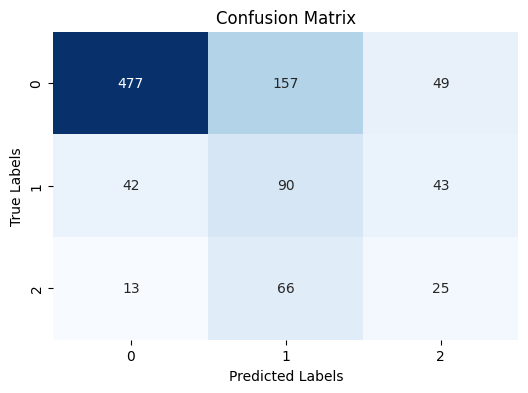


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 477/683 (69.84%)
Class 1: Correct Predictions / Total True Samples = 90/175 (51.43%)
Class 2: Correct Predictions / Total True Samples = 25/104 (24.04%)

Precision-Recall Curves:


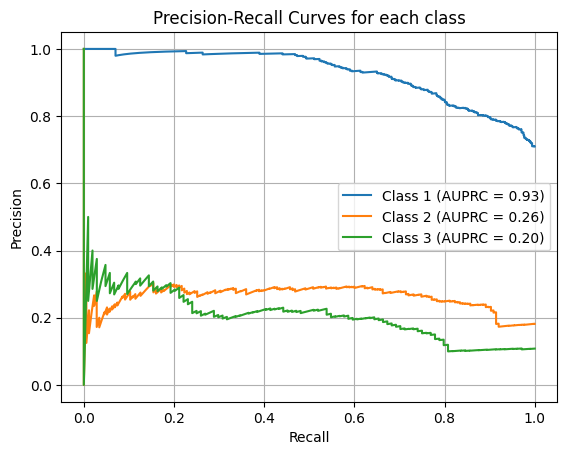


ROC Curves:


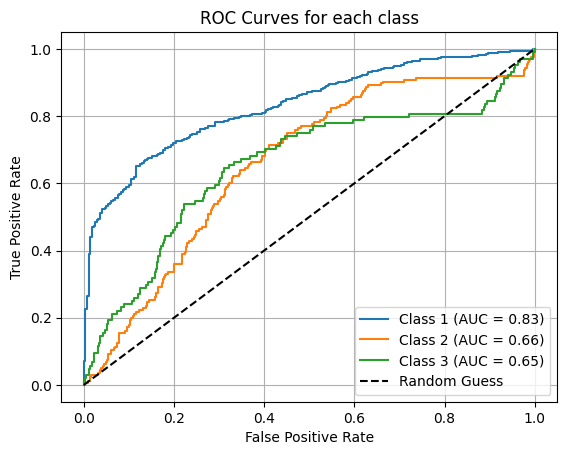


Mean F1 Score: 0.4601
Balanced Accuracy: 0.4844
Average AUPRC: 0.4640

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       683
           1       0.29      0.51      0.37       175
           2       0.21      0.24      0.23       104

    accuracy                           0.62       962
   macro avg       0.47      0.48      0.46       962
weighted avg       0.71      0.62      0.65       962

Accuracy for each fold: [np.float64(0.49745049923263723), np.float64(0.4694973232362049), np.float64(0.5639169960801863), np.float64(0.5579192769184076), np.float64(0.4843532626475526)]
AUPRC for each fold: [np.float64(0.5170306241779404), np.float64(0.45583434957093716), np.float64(0.5328577936580335), np.float64(0.4952733729568737), np.float64(0.46400055023101117)]
Average AUPRC across all folds: 0.49299933811895913
Average Balanced Accuracy across all folds: 0.5146274716229977
_______________________________________

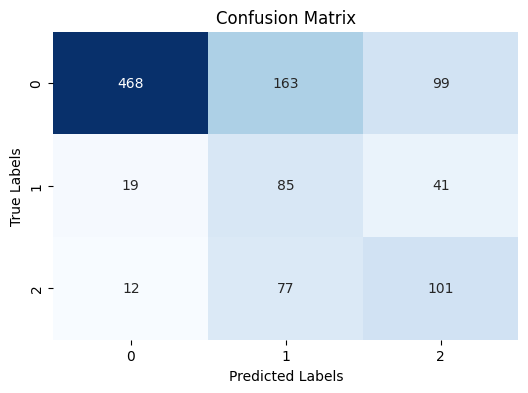


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 468/730 (64.11%)
Class 1: Correct Predictions / Total True Samples = 85/145 (58.62%)
Class 2: Correct Predictions / Total True Samples = 101/190 (53.16%)

Precision-Recall Curves:


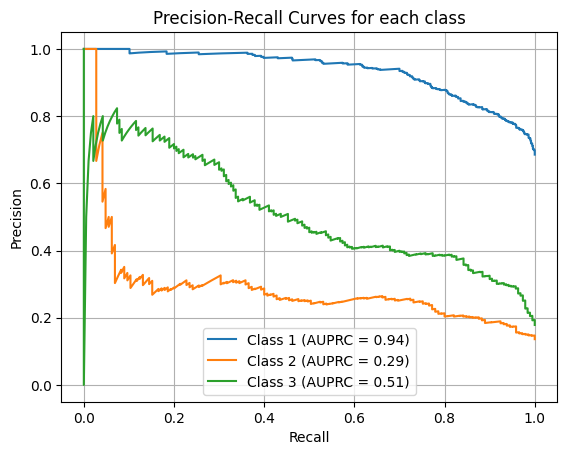


ROC Curves:


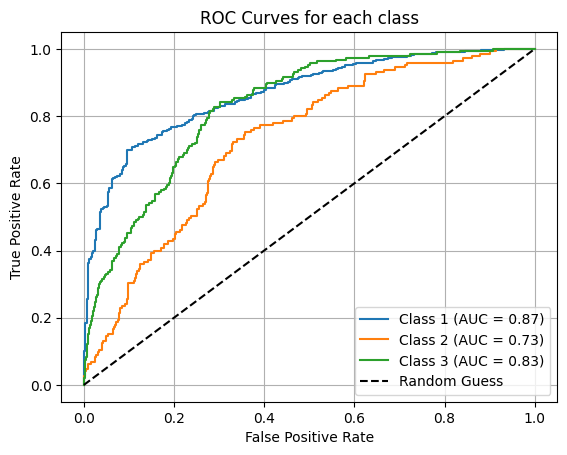


Mean F1 Score: 0.5307
Balanced Accuracy: 0.5863
Average AUPRC: 0.5770

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       730
           1       0.26      0.59      0.36       145
           2       0.42      0.53      0.47       190

    accuracy                           0.61      1065
   macro avg       0.54      0.59      0.53      1065
weighted avg       0.75      0.61      0.65      1065

Fold No: 2
Epoch [1/100], Loss: 1.1051, Accuracy: 0.3691
Validation Loss: 1.0990, Validation Accuracy: 0.4365
Epoch [2/100], Loss: 1.0927, Accuracy: 0.4011
Validation Loss: 1.1323, Validation Accuracy: 0.4307
Epoch [3/100], Loss: 1.0796, Accuracy: 0.4322
Validation Loss: 1.0682, Validation Accuracy: 0.4695
Epoch [4/100], Loss: 1.0468, Accuracy: 0.4934
Validation Loss: 1.0194, Validation Accuracy: 0.5075
Epoch [5/100], Loss: 1.0380, Accuracy: 0.5104
Validation Loss: 0.9700, Validation Accuracy: 0.5098
Epoch [6/100], Los

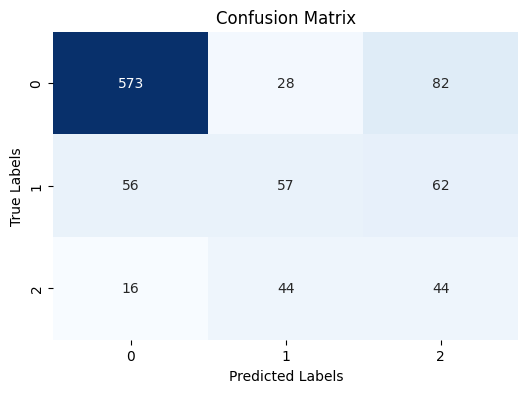


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 573/683 (83.89%)
Class 1: Correct Predictions / Total True Samples = 57/175 (32.57%)
Class 2: Correct Predictions / Total True Samples = 44/104 (42.31%)

Precision-Recall Curves:


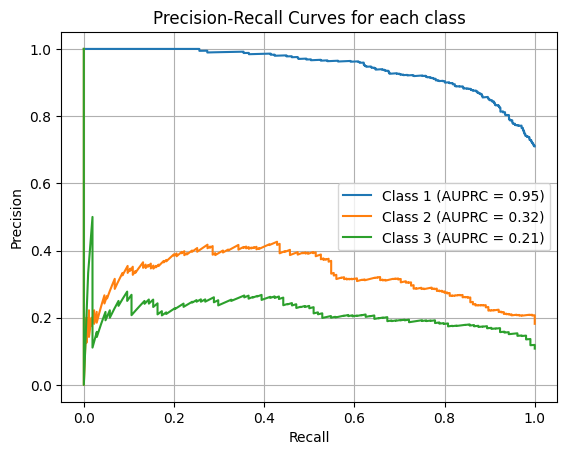


ROC Curves:


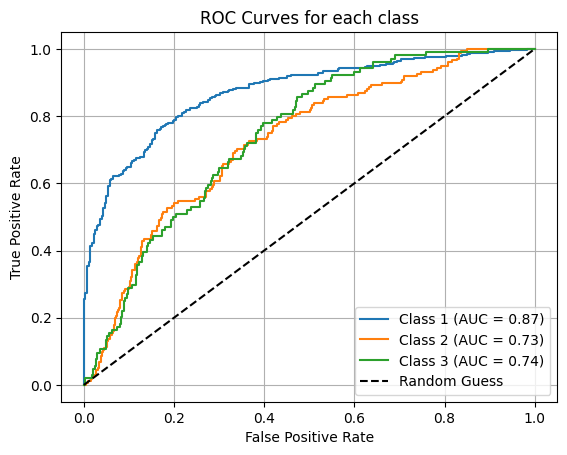


Mean F1 Score: 0.5131
Balanced Accuracy: 0.5292
Average AUPRC: 0.4939

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       683
           1       0.44      0.33      0.38       175
           2       0.23      0.42      0.30       104

    accuracy                           0.70       962
   macro avg       0.52      0.53      0.51       962
weighted avg       0.74      0.70      0.71       962

Fold No: 3
Epoch [1/100], Loss: 1.1112, Accuracy: 0.3567
Validation Loss: 1.1291, Validation Accuracy: 0.4142
Epoch [2/100], Loss: 1.0936, Accuracy: 0.4151
Validation Loss: 1.0749, Validation Accuracy: 0.4582
Epoch [3/100], Loss: 1.0860, Accuracy: 0.4213
Validation Loss: 1.0592, Validation Accuracy: 0.4702
Epoch [4/100], Loss: 1.0721, Accuracy: 0.4579
Validation Loss: 0.9391, Validation Accuracy: 0.3682
Epoch [5/100], Loss: 1.0451, Accuracy: 0.5195
Validation Loss: 1.0554, Validation Accuracy: 0.4139
Epoch [6/100], Los

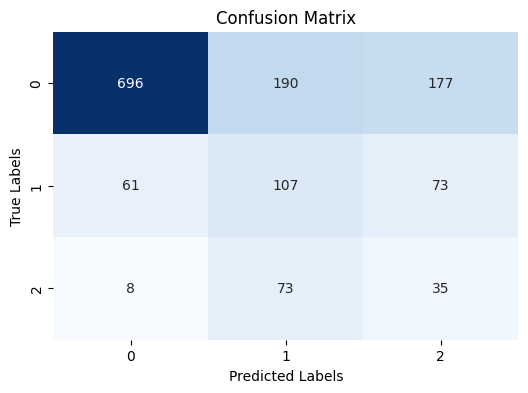


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 696/1063 (65.48%)
Class 1: Correct Predictions / Total True Samples = 107/241 (44.40%)
Class 2: Correct Predictions / Total True Samples = 35/116 (30.17%)

Precision-Recall Curves:


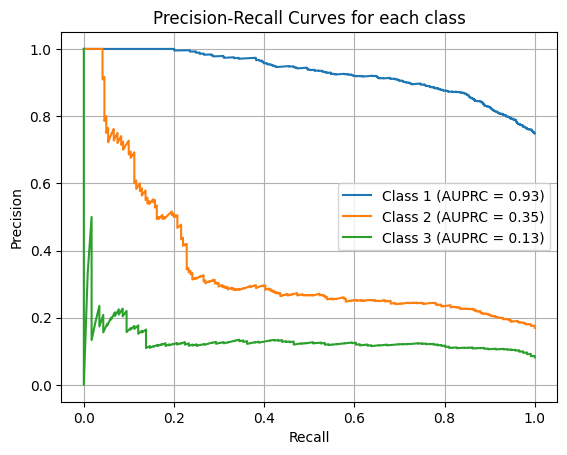


ROC Curves:


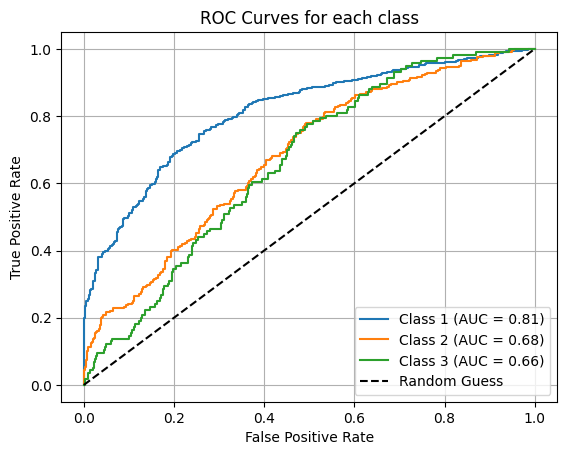


Mean F1 Score: 0.4288
Balanced Accuracy: 0.4668
Average AUPRC: 0.4695

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1063
           1       0.29      0.44      0.35       241
           2       0.12      0.30      0.17       116

    accuracy                           0.59      1420
   macro avg       0.44      0.47      0.43      1420
weighted avg       0.74      0.59      0.64      1420

Fold No: 4
Epoch [1/100], Loss: 1.1217, Accuracy: 0.3463
Validation Loss: 1.0761, Validation Accuracy: 0.4722
Epoch [2/100], Loss: 1.0963, Accuracy: 0.4093
Validation Loss: 1.1909, Validation Accuracy: 0.3697
Epoch [3/100], Loss: 1.0687, Accuracy: 0.4516
Validation Loss: 1.0667, Validation Accuracy: 0.4350
Epoch [4/100], Loss: 1.0621, Accuracy: 0.4655
Validation Loss: 1.0942, Validation Accuracy: 0.5037
Epoch [5/100], Loss: 1.0498, Accuracy: 0.4870
Validation Loss: 0.9660, Validation Accuracy: 0.4412
Epoch [6/100], Los

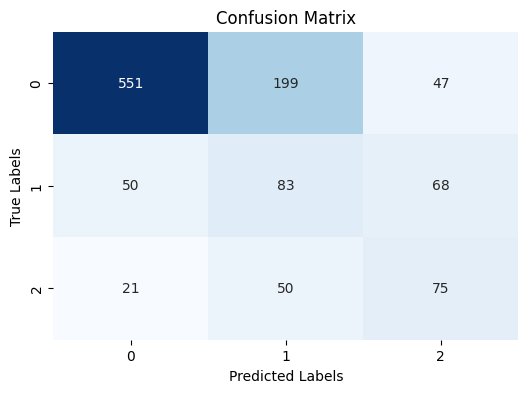


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 551/797 (69.13%)
Class 1: Correct Predictions / Total True Samples = 83/201 (41.29%)
Class 2: Correct Predictions / Total True Samples = 75/146 (51.37%)

Precision-Recall Curves:


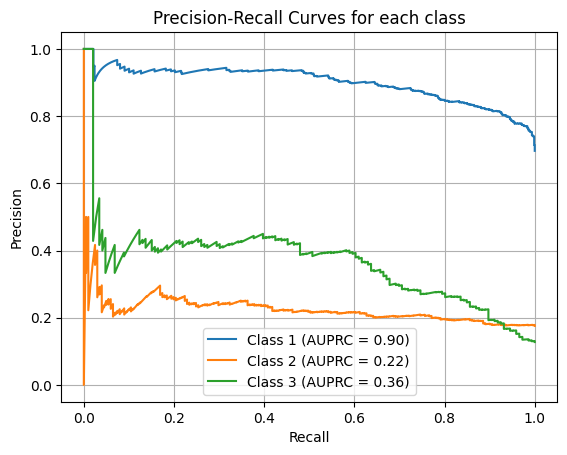


ROC Curves:


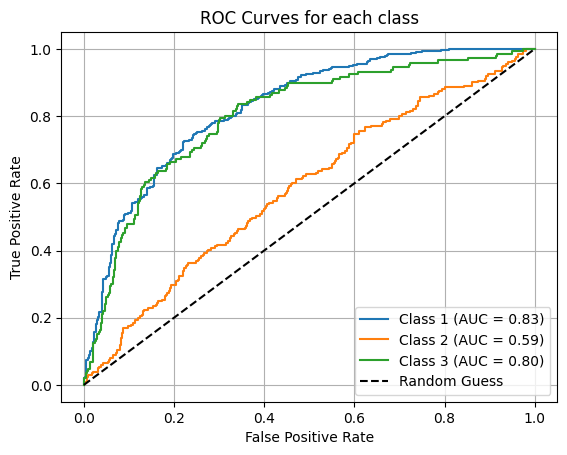


Mean F1 Score: 0.5115
Balanced Accuracy: 0.5393
Average AUPRC: 0.4953

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       797
           1       0.25      0.41      0.31       201
           2       0.39      0.51      0.45       146

    accuracy                           0.62      1144
   macro avg       0.51      0.54      0.51      1144
weighted avg       0.71      0.62      0.65      1144

Fold No: 5
Epoch [1/100], Loss: 1.1114, Accuracy: 0.3341
Validation Loss: 1.1979, Validation Accuracy: 0.3329
Epoch [2/100], Loss: 1.0919, Accuracy: 0.4049
Validation Loss: 1.0106, Validation Accuracy: 0.3721
Epoch [3/100], Loss: 1.0753, Accuracy: 0.4407
Validation Loss: 1.0569, Validation Accuracy: 0.4455
Epoch [4/100], Loss: 1.0608, Accuracy: 0.4561
Validation Loss: 1.2243, Validation Accuracy: 0.4161
Epoch [5/100], Loss: 1.0368, Accuracy: 0.5276
Validation Loss: 1.1417, Validation Accuracy: 0.4640
Epoch [6/100], Los

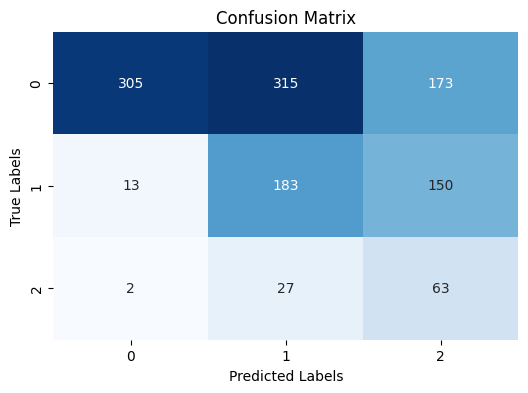


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 305/793 (38.46%)
Class 1: Correct Predictions / Total True Samples = 183/346 (52.89%)
Class 2: Correct Predictions / Total True Samples = 63/92 (68.48%)

Precision-Recall Curves:


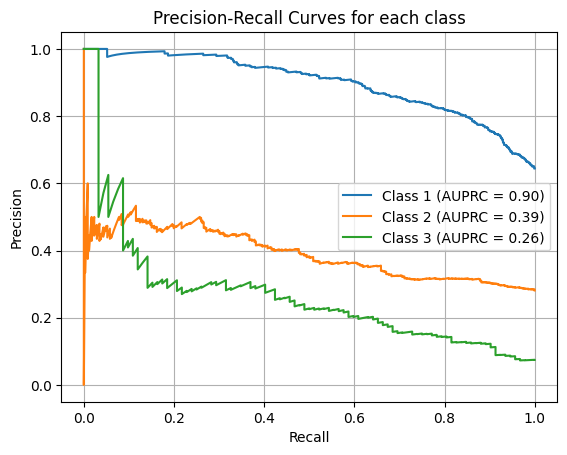


ROC Curves:


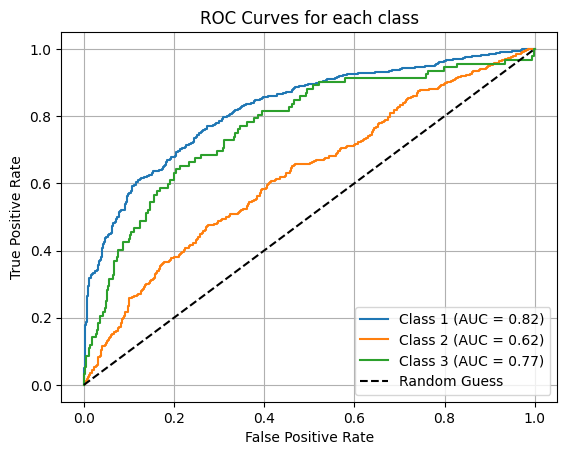


Mean F1 Score: 0.4106
Balanced Accuracy: 0.5328
Average AUPRC: 0.5167

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.38      0.55       793
           1       0.35      0.53      0.42       346
           2       0.16      0.68      0.26        92

    accuracy                           0.45      1231
   macro avg       0.49      0.53      0.41      1231
weighted avg       0.72      0.45      0.49      1231

Accuracy for each fold: [np.float64(0.5862939114437014), np.float64(0.5292456786746685), np.float64(0.4668194153236634), np.float64(0.539325496008154), np.float64(0.5327665758050277)]
AUPRC for each fold: [np.float64(0.5770469537297459), np.float64(0.4939326945457891), np.float64(0.4695151622661597), np.float64(0.49531448703247927), np.float64(0.5166887657946427)]
Average AUPRC across all folds: 0.5104996126737633
Average Balanced Accuracy across all folds: 0.530890215451043
____________________________________________

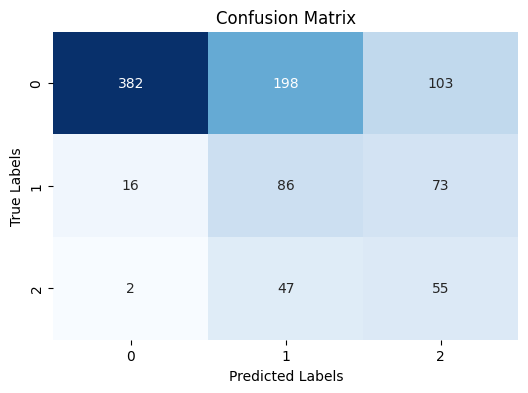


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 382/683 (55.93%)
Class 1: Correct Predictions / Total True Samples = 86/175 (49.14%)
Class 2: Correct Predictions / Total True Samples = 55/104 (52.88%)

Precision-Recall Curves:


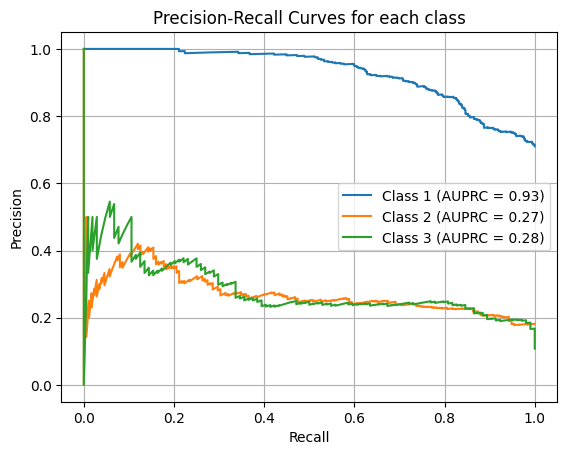


ROC Curves:


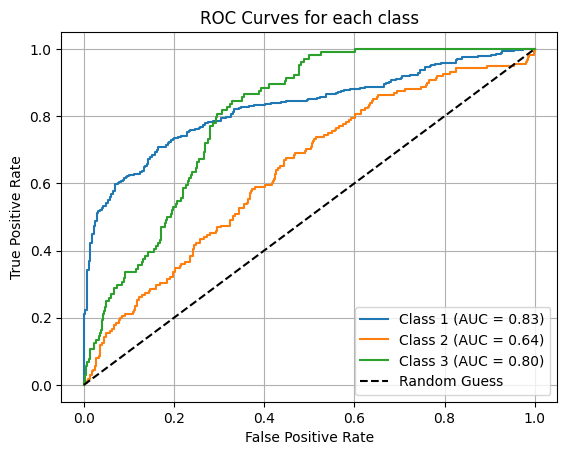


Mean F1 Score: 0.4579
Balanced Accuracy: 0.5265
Average AUPRC: 0.4928

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.56      0.71       683
           1       0.26      0.49      0.34       175
           2       0.24      0.53      0.33       104

    accuracy                           0.54       962
   macro avg       0.48      0.53      0.46       962
weighted avg       0.75      0.54      0.60       962

Fold No: 2
Epoch [1/100], Loss: 1.1178, Accuracy: 0.3357
Validation Loss: 1.0273, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1070, Accuracy: 0.3435
Validation Loss: 1.1943, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1040, Accuracy: 0.3396
Validation Loss: 1.0350, Validation Accuracy: 0.3819
Epoch [4/100], Loss: 1.0628, Accuracy: 0.4626
Validation Loss: 0.9847, Validation Accuracy: 0.4165
Epoch [5/100], Loss: 1.0296, Accuracy: 0.5460
Validation Loss: 1.0707, Validation Accuracy: 0.4168
Epoch [6/100], Los

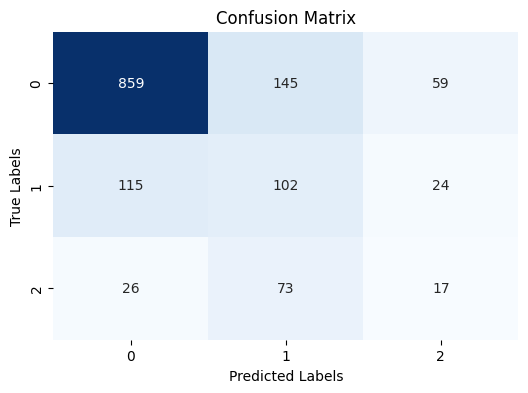


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 859/1063 (80.81%)
Class 1: Correct Predictions / Total True Samples = 102/241 (42.32%)
Class 2: Correct Predictions / Total True Samples = 17/116 (14.66%)

Precision-Recall Curves:


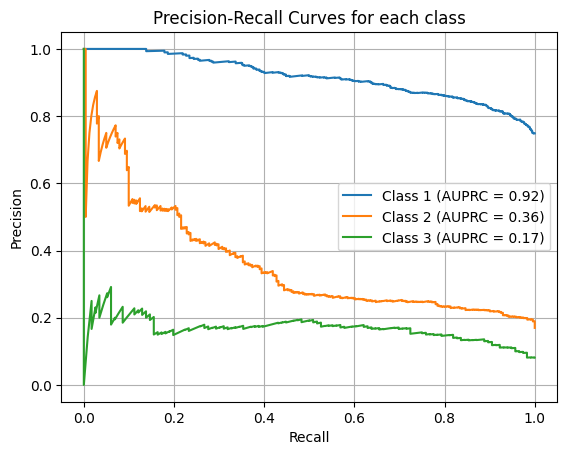


ROC Curves:


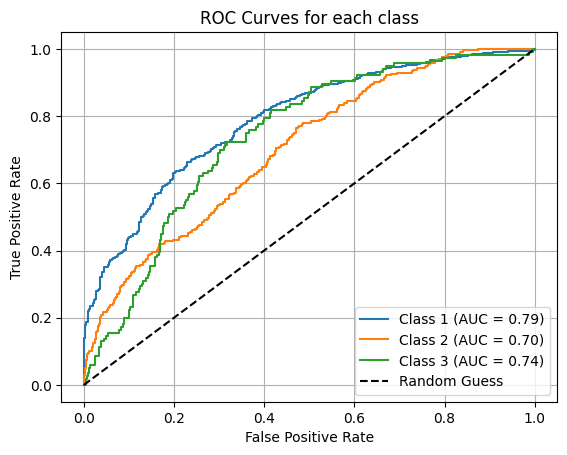


Mean F1 Score: 0.4513
Balanced Accuracy: 0.4593
Average AUPRC: 0.4803

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1063
           1       0.32      0.42      0.36       241
           2       0.17      0.15      0.16       116

    accuracy                           0.69      1420
   macro avg       0.45      0.46      0.45      1420
weighted avg       0.71      0.69      0.70      1420

Fold No: 3
Epoch [1/100], Loss: 1.1125, Accuracy: 0.3372
Validation Loss: 1.1934, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1050, Accuracy: 0.3626
Validation Loss: 1.2079, Validation Accuracy: 0.3801
Epoch [3/100], Loss: 1.0707, Accuracy: 0.4308
Validation Loss: 1.1611, Validation Accuracy: 0.4348
Epoch [4/100], Loss: 1.0547, Accuracy: 0.4825
Validation Loss: 1.0363, Validation Accuracy: 0.4143
Epoch [5/100], Loss: 1.0457, Accuracy: 0.5039
Validation Loss: 0.9979, Validation Accuracy: 0.4459
Epoch [6/100], Los

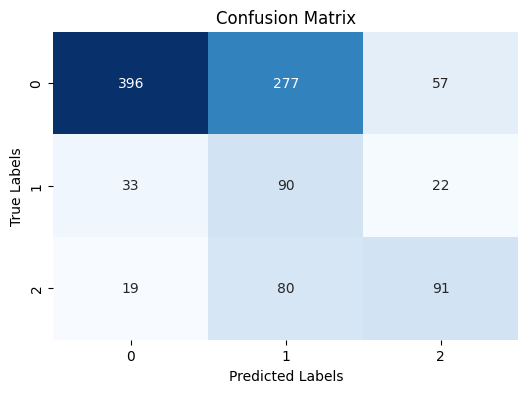


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 396/730 (54.25%)
Class 1: Correct Predictions / Total True Samples = 90/145 (62.07%)
Class 2: Correct Predictions / Total True Samples = 91/190 (47.89%)

Precision-Recall Curves:


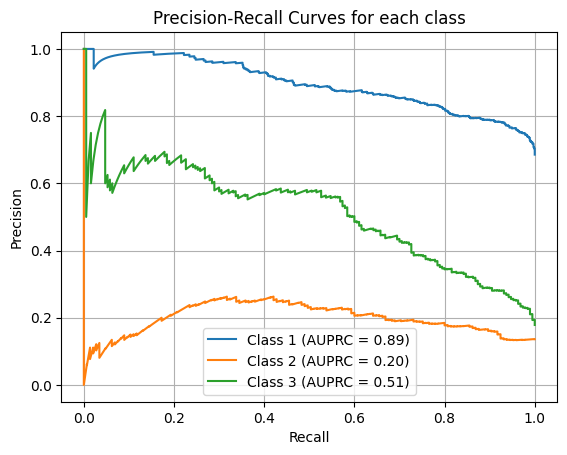


ROC Curves:


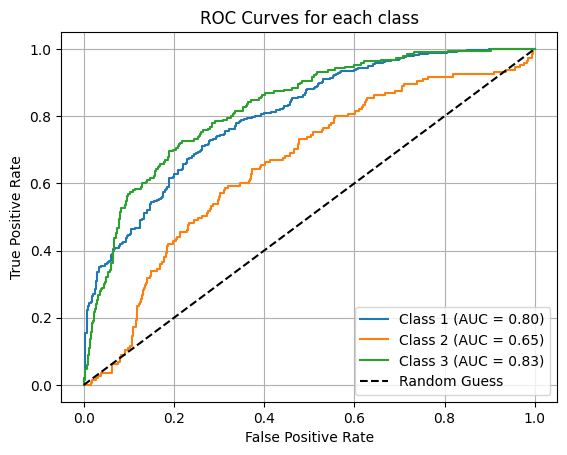


Mean F1 Score: 0.4940
Balanced Accuracy: 0.5474
Average AUPRC: 0.5331

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.54      0.67       730
           1       0.20      0.62      0.30       145
           2       0.54      0.48      0.51       190

    accuracy                           0.54      1065
   macro avg       0.54      0.55      0.49      1065
weighted avg       0.73      0.54      0.59      1065

Fold No: 4
Epoch [1/100], Loss: 1.1145, Accuracy: 0.3115
Validation Loss: 1.1573, Validation Accuracy: 0.3328
Epoch [2/100], Loss: 1.1013, Accuracy: 0.3670
Validation Loss: 1.0571, Validation Accuracy: 0.3722
Epoch [3/100], Loss: 1.0994, Accuracy: 0.3643
Validation Loss: 1.0839, Validation Accuracy: 0.3419
Epoch [4/100], Loss: 1.1086, Accuracy: 0.3215
Validation Loss: 1.1211, Validation Accuracy: 0.3819
Epoch [5/100], Loss: 1.0829, Accuracy: 0.4035
Validation Loss: 1.0639, Validation Accuracy: 0.4449
Epoch [6/100], Los

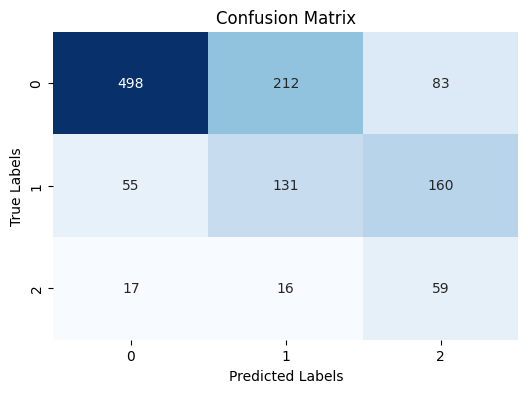


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 498/793 (62.80%)
Class 1: Correct Predictions / Total True Samples = 131/346 (37.86%)
Class 2: Correct Predictions / Total True Samples = 59/92 (64.13%)

Precision-Recall Curves:


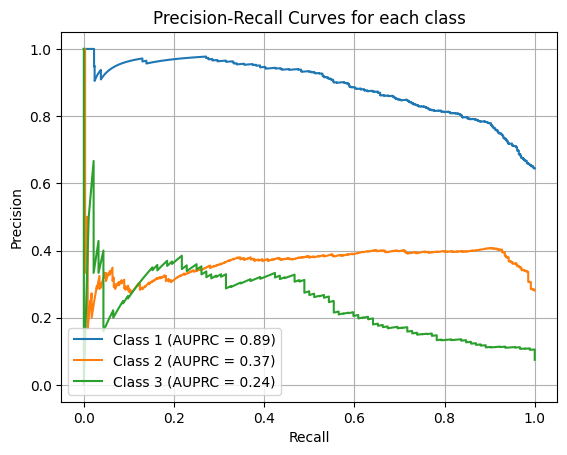


ROC Curves:


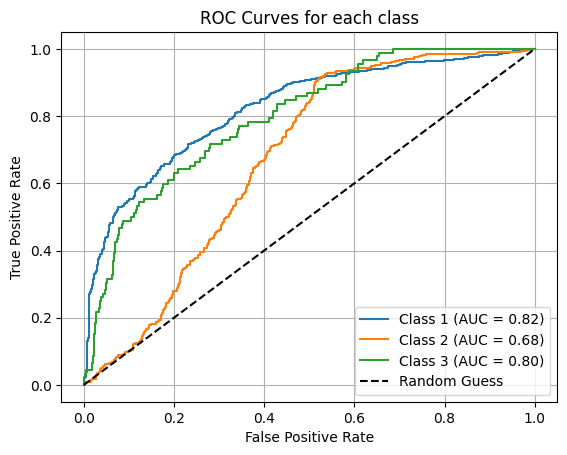


Mean F1 Score: 0.4673
Balanced Accuracy: 0.5493
Average AUPRC: 0.4988

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.63      0.73       793
           1       0.36      0.38      0.37       346
           2       0.20      0.64      0.30        92

    accuracy                           0.56      1231
   macro avg       0.48      0.55      0.47      1231
weighted avg       0.68      0.56      0.60      1231

Fold No: 5
Epoch [1/100], Loss: 1.1205, Accuracy: 0.3317
Validation Loss: 1.1333, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1023, Accuracy: 0.3602
Validation Loss: 1.0575, Validation Accuracy: 0.3549
Epoch [3/100], Loss: 1.0963, Accuracy: 0.3764
Validation Loss: 1.2029, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1063, Accuracy: 0.3309
Validation Loss: 1.1339, Validation Accuracy: 0.3333
Epoch [5/100], Loss: 1.1020, Accuracy: 0.3236
Validation Loss: 1.1107, Validation Accuracy: 0.3333
Epoch [6/100], Los

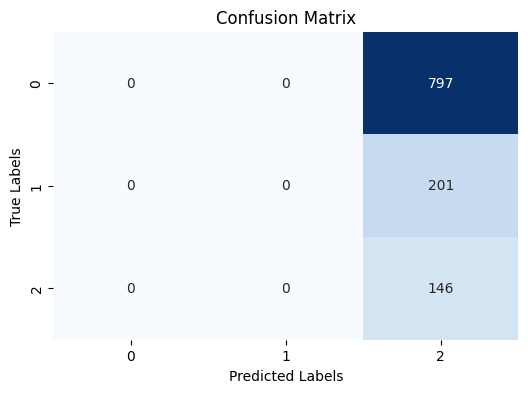


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 0/797 (0.00%)
Class 1: Correct Predictions / Total True Samples = 0/201 (0.00%)
Class 2: Correct Predictions / Total True Samples = 146/146 (100.00%)

Precision-Recall Curves:


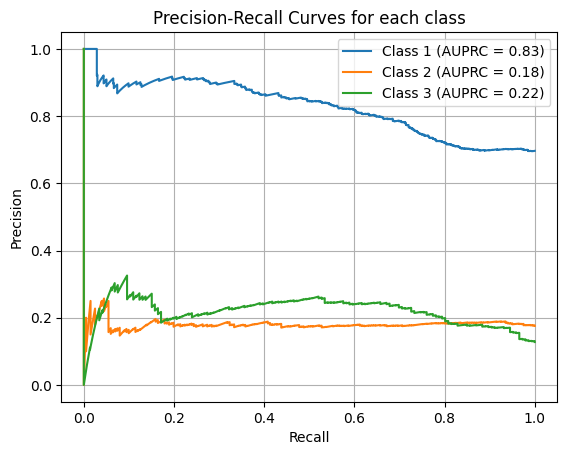


ROC Curves:


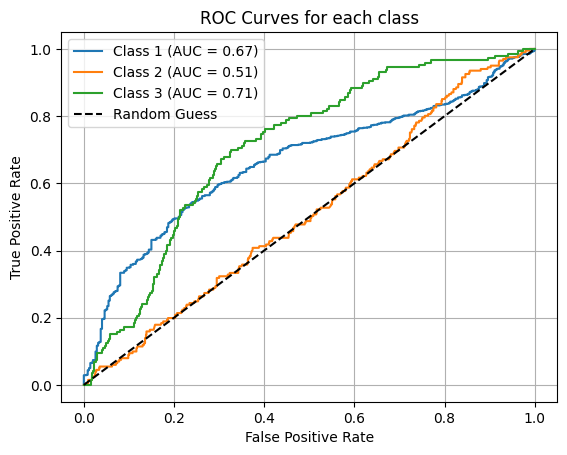


Mean F1 Score: 0.0755
Balanced Accuracy: 0.3333
Average AUPRC: 0.4082

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       797
           1       0.00      0.00      0.00       201
           2       0.13      1.00      0.23       146

    accuracy                           0.13      1144
   macro avg       0.04      0.33      0.08      1144
weighted avg       0.02      0.13      0.03      1144

Accuracy for each fold: [np.float64(0.5265239811433076), np.float64(0.45929284970096584), np.float64(0.5473675923393747), np.float64(0.5493040068176337), np.float64(0.3333333333333333)]
AUPRC for each fold: [np.float64(0.49283902774338495), np.float64(0.480272384939265), np.float64(0.533056848237618), np.float64(0.49882611237741076), np.float64(0.4081937151119524)]
Average AUPRC across all folds: 0.4826376176819262
Average Balanced Accuracy across all folds: 0.48316435266692304
_________________________________________

c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Epoch [1/100], Loss: 1.1065, Accuracy: 0.3864
Validation Loss: 1.0174, Validation Accuracy: 0.4498
Epoch [2/100], Loss: 1.0623, Accuracy: 0.4621
Validation Loss: 0.9969, Validation Accuracy: 0.5353
Epoch [3/100], Loss: 1.0253, Accuracy: 0.5409
Validation Loss: 1.0329, Validation Accuracy: 0.5277
Epoch [4/100], Loss: 0.9968, Accuracy: 0.5833
Validation Loss: 0.9635, Validation Accuracy: 0.5720
Epoch [5/100], Loss: 0.9974, Accuracy: 0.5917
Validation Loss: 1.0905, Validation Accuracy: 0.5041
Epoch [6/100], Loss: 0.9808, Accuracy: 0.6250
Validation Loss: 1.0328, Validation Accuracy: 0.5423
Epoch [7/100], Loss: 0.9569, Accuracy: 0.6402
Validation Loss: 0.9663, Validation Accuracy: 0.5612
Epoch [8/100], Loss: 0.9563, Accuracy: 0.6470
Validation Loss: 0.9795, Validation Accuracy: 0.5233
Epoch [9/100], Loss: 0.9444, Accuracy: 0.6500
Validation Loss: 0.9948, Validation Accuracy: 0.5764
Epoch [10/100], Loss: 0.9359, Accuracy: 0.6591
Validation Loss: 0.9867, Validation Accuracy: 0.5565
Epoch [11

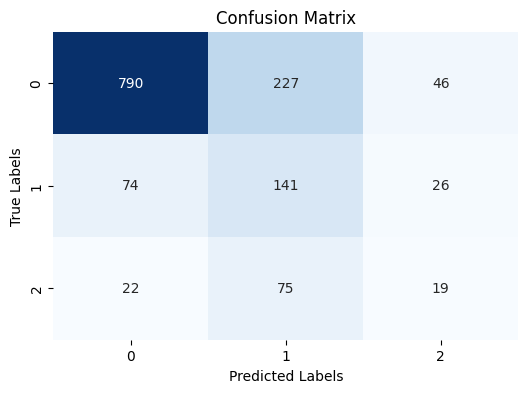


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 790/1063 (74.32%)
Class 1: Correct Predictions / Total True Samples = 141/241 (58.51%)
Class 2: Correct Predictions / Total True Samples = 19/116 (16.38%)

Precision-Recall Curves:


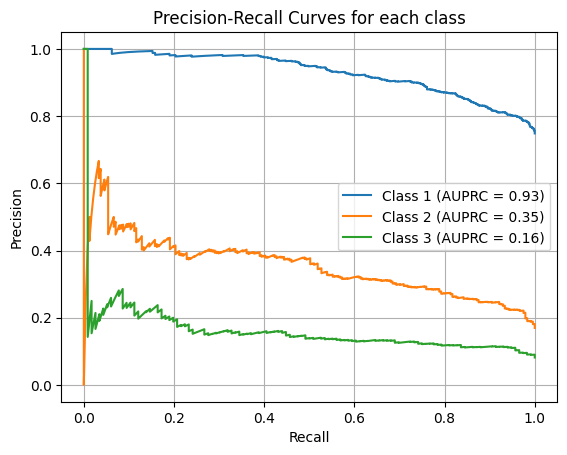


ROC Curves:


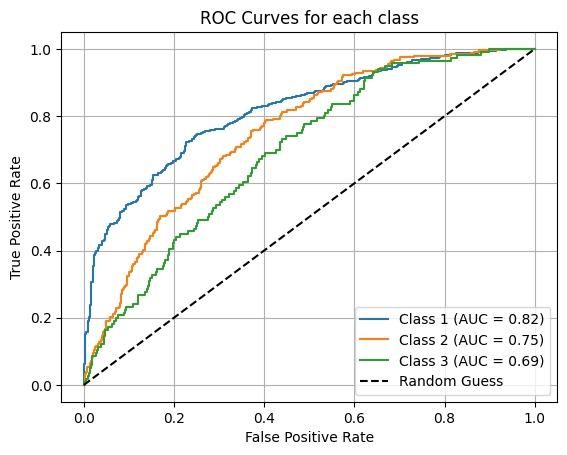


Mean F1 Score: 0.4688
Balanced Accuracy: 0.4973
Average AUPRC: 0.4796

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1063
           1       0.32      0.59      0.41       241
           2       0.21      0.16      0.18       116

    accuracy                           0.67      1420
   macro avg       0.47      0.50      0.47      1420
weighted avg       0.74      0.67      0.69      1420

Fold No: 2
Epoch [1/100], Loss: 1.1313, Accuracy: 0.3411
Validation Loss: 1.0696, Validation Accuracy: 0.3862
Epoch [2/100], Loss: 1.0667, Accuracy: 0.4542
Validation Loss: 1.0647, Validation Accuracy: 0.4005
Epoch [3/100], Loss: 1.0192, Accuracy: 0.5406
Validation Loss: 0.9777, Validation Accuracy: 0.4166
Epoch [4/100], Loss: 0.9892, Accuracy: 0.5872
Validation Loss: 0.9361, Validation Accuracy: 0.5432
Epoch [5/100], Loss: 0.9769, Accuracy: 0.6209
Validation Loss: 0.9260, Validation Accuracy: 0.4496
Epoch [6/100], Los

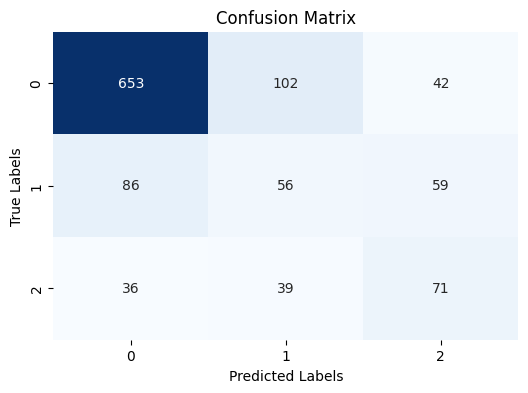


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 653/797 (81.93%)
Class 1: Correct Predictions / Total True Samples = 56/201 (27.86%)
Class 2: Correct Predictions / Total True Samples = 71/146 (48.63%)

Precision-Recall Curves:


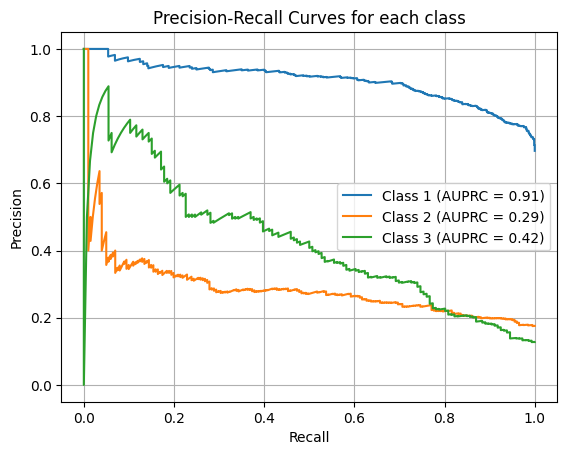


ROC Curves:


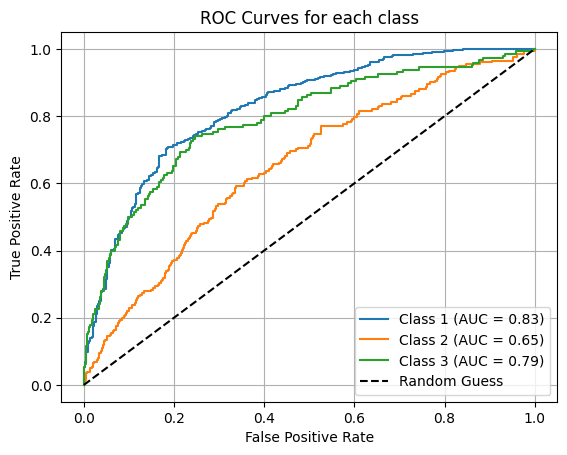


Mean F1 Score: 0.5196
Balanced Accuracy: 0.5281
Average AUPRC: 0.5371

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       797
           1       0.28      0.28      0.28       201
           2       0.41      0.49      0.45       146

    accuracy                           0.68      1144
   macro avg       0.51      0.53      0.52      1144
weighted avg       0.69      0.68      0.69      1144

Fold No: 3
Epoch [1/100], Loss: 1.1156, Accuracy: 0.3611
Validation Loss: 1.1279, Validation Accuracy: 0.3813
Epoch [2/100], Loss: 1.0671, Accuracy: 0.4797
Validation Loss: 0.9858, Validation Accuracy: 0.3893
Epoch [3/100], Loss: 1.0526, Accuracy: 0.4893
Validation Loss: 1.0209, Validation Accuracy: 0.4099
Epoch [4/100], Loss: 1.0515, Accuracy: 0.4904
Validation Loss: 1.1336, Validation Accuracy: 0.4376
Epoch [5/100], Loss: 1.0089, Accuracy: 0.5737
Validation Loss: 1.0841, Validation Accuracy: 0.4290
Epoch [6/100], Los

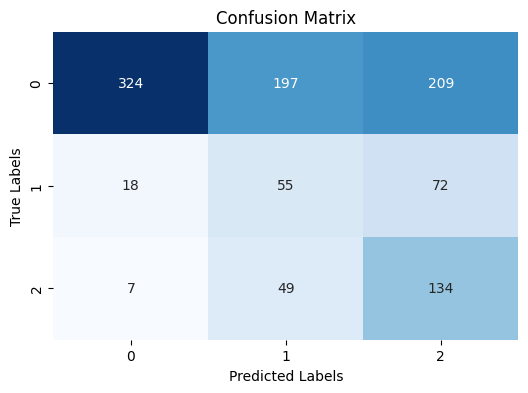


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 324/730 (44.38%)
Class 1: Correct Predictions / Total True Samples = 55/145 (37.93%)
Class 2: Correct Predictions / Total True Samples = 134/190 (70.53%)

Precision-Recall Curves:


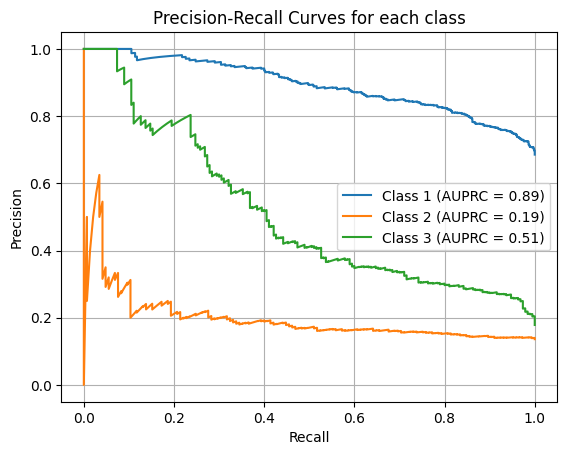


ROC Curves:


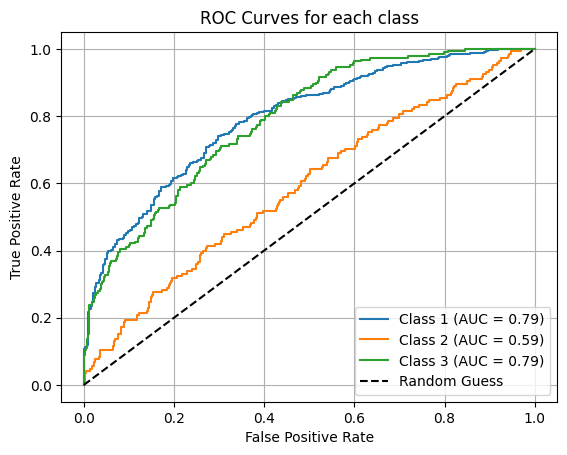


Mean F1 Score: 0.4301
Balanced Accuracy: 0.5095
Average AUPRC: 0.5312

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.44      0.60       730
           1       0.18      0.38      0.25       145
           2       0.32      0.71      0.44       190

    accuracy                           0.48      1065
   macro avg       0.48      0.51      0.43      1065
weighted avg       0.72      0.48      0.52      1065

Fold No: 4
Epoch [1/100], Loss: 1.1285, Accuracy: 0.3559
Validation Loss: 0.9977, Validation Accuracy: 0.3392
Epoch [2/100], Loss: 1.1123, Accuracy: 0.4077
Validation Loss: 1.0436, Validation Accuracy: 0.4303
Epoch [3/100], Loss: 1.0543, Accuracy: 0.5000
Validation Loss: 0.9875, Validation Accuracy: 0.4627
Epoch [4/100], Loss: 1.0149, Accuracy: 0.5593
Validation Loss: 1.0727, Validation Accuracy: 0.4753
Epoch [5/100], Loss: 1.0074, Accuracy: 0.5847
Validation Loss: 0.9769, Validation Accuracy: 0.4944
Epoch [6/100], Los

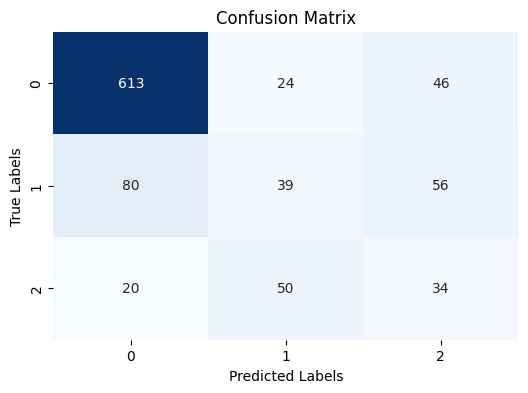


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 613/683 (89.75%)
Class 1: Correct Predictions / Total True Samples = 39/175 (22.29%)
Class 2: Correct Predictions / Total True Samples = 34/104 (32.69%)

Precision-Recall Curves:


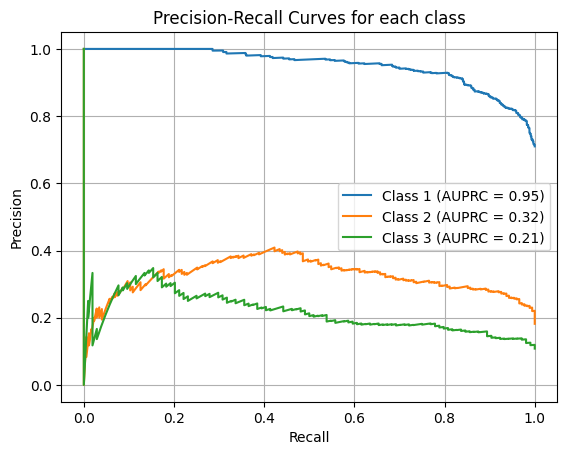


ROC Curves:


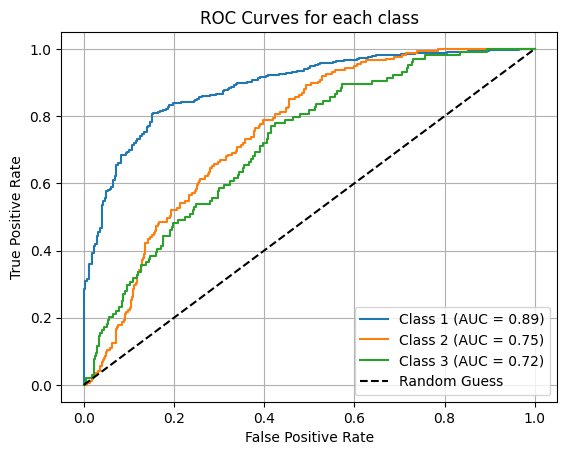


Mean F1 Score: 0.4775
Balanced Accuracy: 0.4824
Average AUPRC: 0.4944

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       683
           1       0.35      0.22      0.27       175
           2       0.25      0.33      0.28       104

    accuracy                           0.71       962
   macro avg       0.48      0.48      0.48       962
weighted avg       0.70      0.71      0.70       962

Fold No: 5
Epoch [1/100], Loss: 1.1081, Accuracy: 0.3680
Validation Loss: 1.1209, Validation Accuracy: 0.3331
Epoch [2/100], Loss: 1.0647, Accuracy: 0.4712
Validation Loss: 0.9136, Validation Accuracy: 0.3567
Epoch [3/100], Loss: 1.0167, Accuracy: 0.5413
Validation Loss: 0.9219, Validation Accuracy: 0.5016
Epoch [4/100], Loss: 0.9768, Accuracy: 0.6150
Validation Loss: 1.1161, Validation Accuracy: 0.4205
Epoch [5/100], Loss: 0.9702, Accuracy: 0.6217
Validation Loss: 0.9019, Validation Accuracy: 0.4773
Epoch [6/100], Los

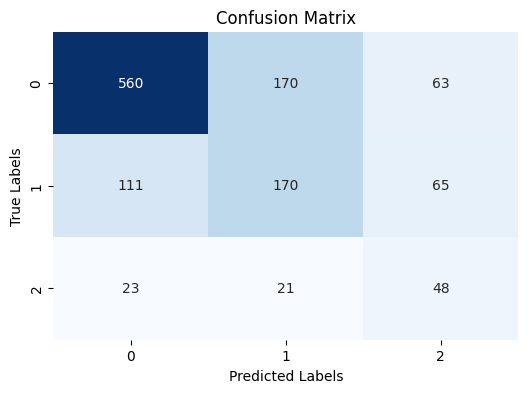


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 560/793 (70.62%)
Class 1: Correct Predictions / Total True Samples = 170/346 (49.13%)
Class 2: Correct Predictions / Total True Samples = 48/92 (52.17%)

Precision-Recall Curves:


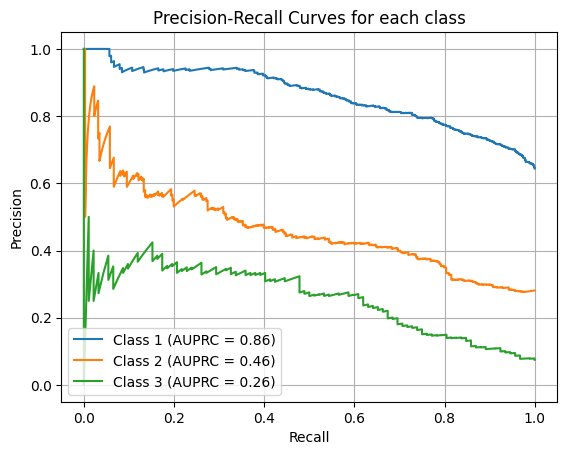


ROC Curves:


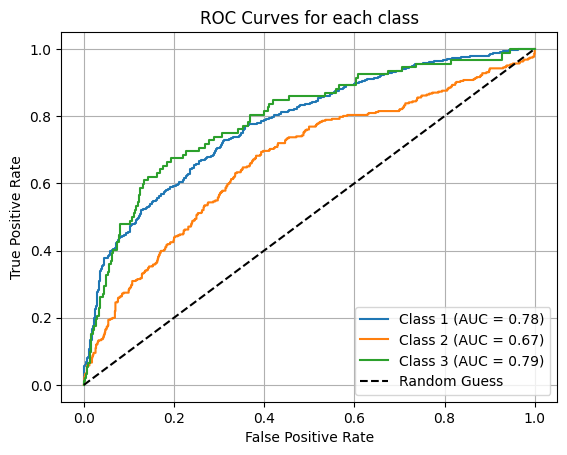


Mean F1 Score: 0.5308
Balanced Accuracy: 0.5731
Average AUPRC: 0.5257

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.75       793
           1       0.47      0.49      0.48       346
           2       0.27      0.52      0.36        92

    accuracy                           0.63      1231
   macro avg       0.52      0.57      0.53      1231
weighted avg       0.67      0.63      0.65      1231

Accuracy for each fold: [np.float64(0.49734500808756454), np.float64(0.5280769314197419), np.float64(0.509469706386893), np.float64(0.48243040024884826), np.float64(0.573082559012791)]
AUPRC for each fold: [np.float64(0.4795713442461382), np.float64(0.5370755011600449), np.float64(0.5311768692824231), np.float64(0.49435855225652015), np.float64(0.5256986127269218)]
Average AUPRC across all folds: 0.5135761759344096
Average Balanced Accuracy across all folds: 0.5180809210311678
__________________________________________

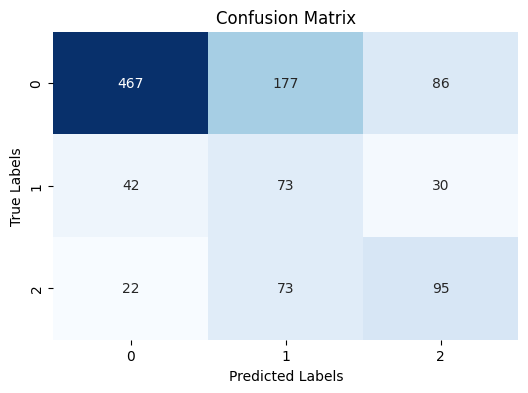


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 467/730 (63.97%)
Class 1: Correct Predictions / Total True Samples = 73/145 (50.34%)
Class 2: Correct Predictions / Total True Samples = 95/190 (50.00%)

Precision-Recall Curves:


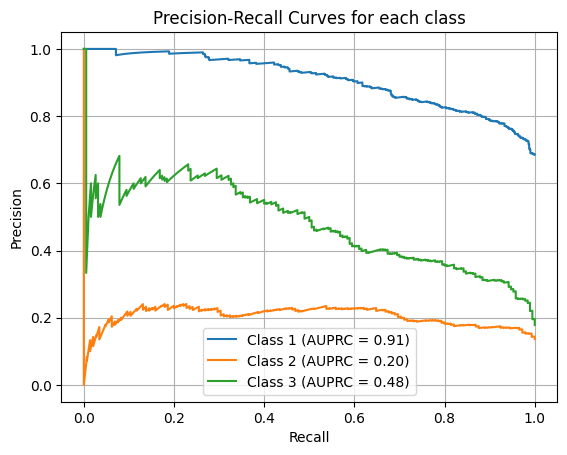


ROC Curves:


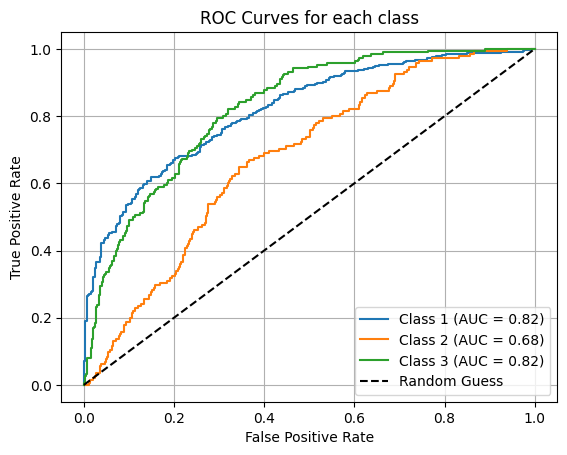


Mean F1 Score: 0.5088
Balanced Accuracy: 0.5477
Average AUPRC: 0.5294

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       730
           1       0.23      0.50      0.31       145
           2       0.45      0.50      0.47       190

    accuracy                           0.60      1065
   macro avg       0.52      0.55      0.51      1065
weighted avg       0.71      0.60      0.63      1065

Fold No: 2
Epoch [1/100], Loss: 1.1112, Accuracy: 0.3719
Validation Loss: 1.0694, Validation Accuracy: 0.3713
Epoch [2/100], Loss: 1.1011, Accuracy: 0.3898
Validation Loss: 1.0962, Validation Accuracy: 0.4512
Epoch [3/100], Loss: 1.0709, Accuracy: 0.4548
Validation Loss: 1.1127, Validation Accuracy: 0.4855
Epoch [4/100], Loss: 1.0394, Accuracy: 0.5151
Validation Loss: 1.0399, Validation Accuracy: 0.4568
Epoch [5/100], Loss: 1.0301, Accuracy: 0.5320
Validation Loss: 0.9865, Validation Accuracy: 0.5130
Epoch [6/100], Los

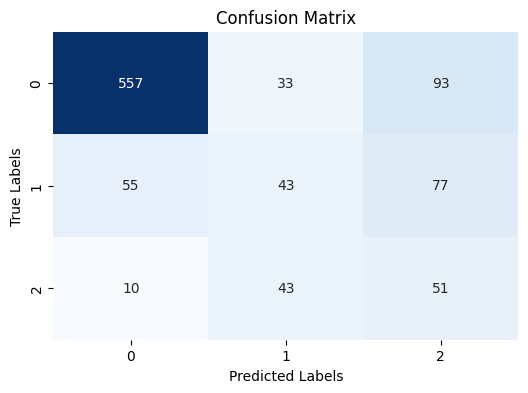


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 557/683 (81.55%)
Class 1: Correct Predictions / Total True Samples = 43/175 (24.57%)
Class 2: Correct Predictions / Total True Samples = 51/104 (49.04%)

Precision-Recall Curves:


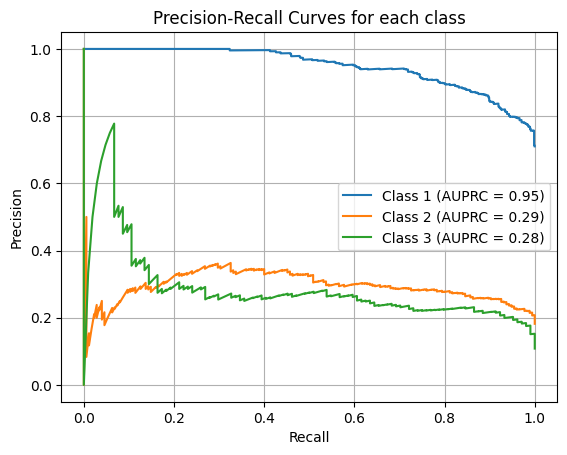


ROC Curves:


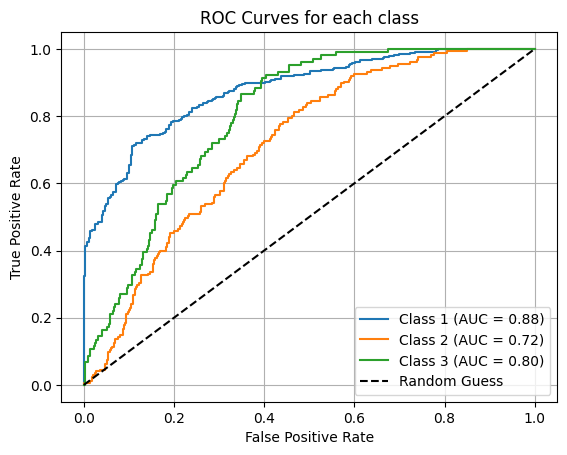


Mean F1 Score: 0.4867
Balanced Accuracy: 0.5172
Average AUPRC: 0.5077

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.85       683
           1       0.36      0.25      0.29       175
           2       0.23      0.49      0.31       104

    accuracy                           0.68       962
   macro avg       0.50      0.52      0.49       962
weighted avg       0.73      0.68      0.69       962

Fold No: 3
Epoch [1/100], Loss: 1.1122, Accuracy: 0.3614
Validation Loss: 1.1540, Validation Accuracy: 0.3042
Epoch [2/100], Loss: 1.0835, Accuracy: 0.4115
Validation Loss: 0.9719, Validation Accuracy: 0.3559
Epoch [3/100], Loss: 1.0725, Accuracy: 0.4521
Validation Loss: 1.1309, Validation Accuracy: 0.4414
Epoch [4/100], Loss: 1.0323, Accuracy: 0.5265
Validation Loss: 0.9884, Validation Accuracy: 0.5493
Epoch [5/100], Loss: 1.0078, Accuracy: 0.5782
Validation Loss: 1.0188, Validation Accuracy: 0.5414
Epoch [6/100], Los

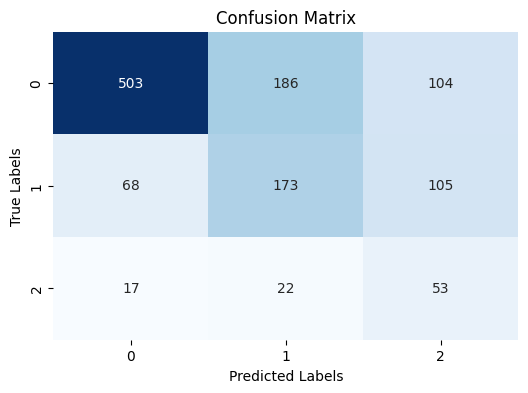


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 503/793 (63.43%)
Class 1: Correct Predictions / Total True Samples = 173/346 (50.00%)
Class 2: Correct Predictions / Total True Samples = 53/92 (57.61%)

Precision-Recall Curves:


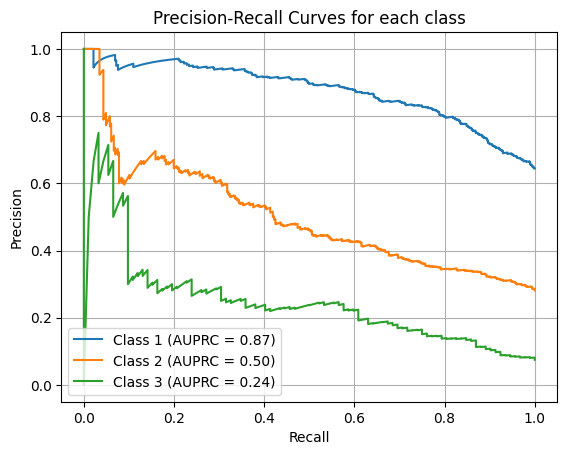


ROC Curves:


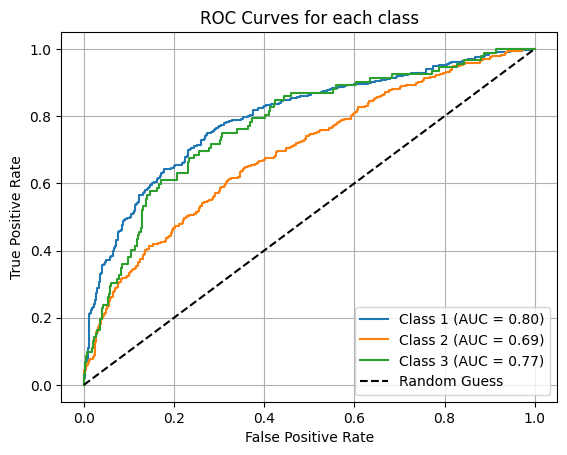


Mean F1 Score: 0.5013
Balanced Accuracy: 0.5701
Average AUPRC: 0.5392

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       793
           1       0.45      0.50      0.48       346
           2       0.20      0.58      0.30        92

    accuracy                           0.59      1231
   macro avg       0.50      0.57      0.50      1231
weighted avg       0.69      0.59      0.63      1231

Fold No: 4
Epoch [1/100], Loss: 1.1137, Accuracy: 0.3691
Validation Loss: 1.1169, Validation Accuracy: 0.4466
Epoch [2/100], Loss: 1.0930, Accuracy: 0.4000
Validation Loss: 1.0868, Validation Accuracy: 0.4923
Epoch [3/100], Loss: 1.0532, Accuracy: 0.4894
Validation Loss: 0.9822, Validation Accuracy: 0.4582
Epoch [4/100], Loss: 1.0193, Accuracy: 0.5455
Validation Loss: 1.0992, Validation Accuracy: 0.4409
Epoch [5/100], Loss: 1.0074, Accuracy: 0.5675
Validation Loss: 0.9658, Validation Accuracy: 0.4615
Epoch [6/100], Los

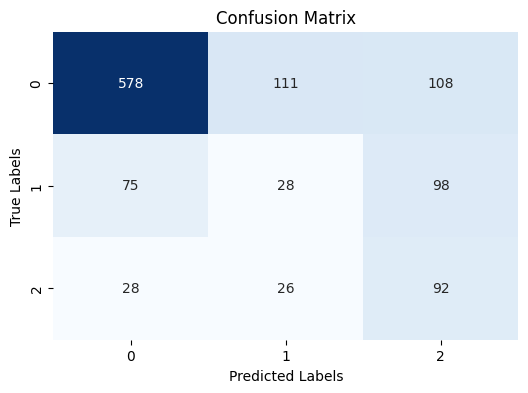


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 578/797 (72.52%)
Class 1: Correct Predictions / Total True Samples = 28/201 (13.93%)
Class 2: Correct Predictions / Total True Samples = 92/146 (63.01%)

Precision-Recall Curves:


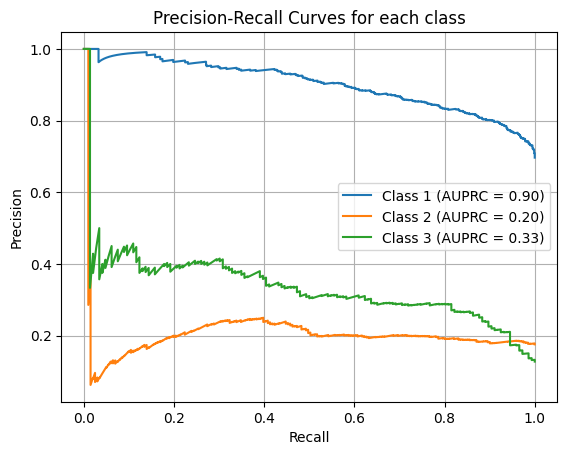


ROC Curves:


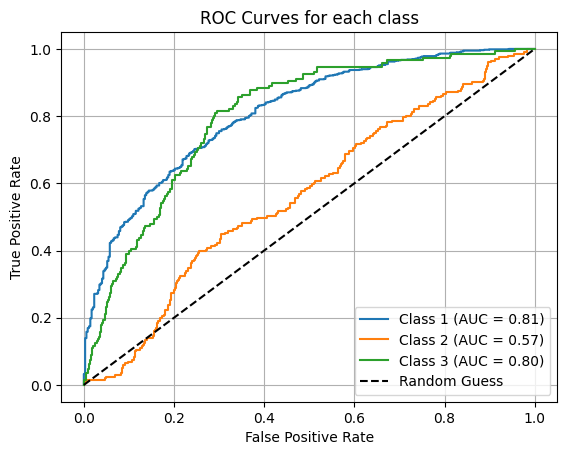


Mean F1 Score: 0.4499
Balanced Accuracy: 0.4982
Average AUPRC: 0.4803

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       797
           1       0.17      0.14      0.15       201
           2       0.31      0.63      0.41       146

    accuracy                           0.61      1144
   macro avg       0.44      0.50      0.45      1144
weighted avg       0.66      0.61      0.62      1144

Fold No: 5
Epoch [1/100], Loss: 1.1084, Accuracy: 0.3670
Validation Loss: 1.0186, Validation Accuracy: 0.3920
Epoch [2/100], Loss: 1.0960, Accuracy: 0.3843
Validation Loss: 1.0260, Validation Accuracy: 0.4727
Epoch [3/100], Loss: 1.0728, Accuracy: 0.4352
Validation Loss: 0.9657, Validation Accuracy: 0.4871
Epoch [4/100], Loss: 1.0428, Accuracy: 0.5250
Validation Loss: 0.9603, Validation Accuracy: 0.5118
Epoch [5/100], Loss: 1.0149, Accuracy: 0.5389
Validation Loss: 1.1342, Validation Accuracy: 0.4968
Epoch [6/100], Los

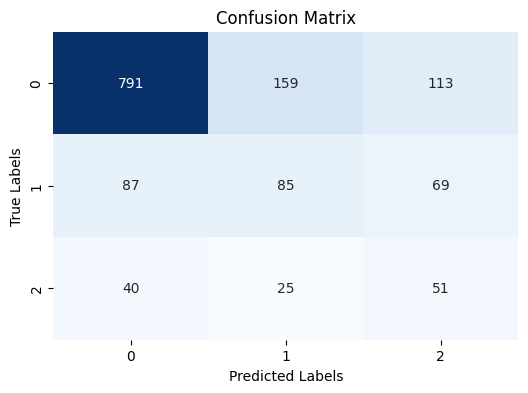


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 791/1063 (74.41%)
Class 1: Correct Predictions / Total True Samples = 85/241 (35.27%)
Class 2: Correct Predictions / Total True Samples = 51/116 (43.97%)

Precision-Recall Curves:


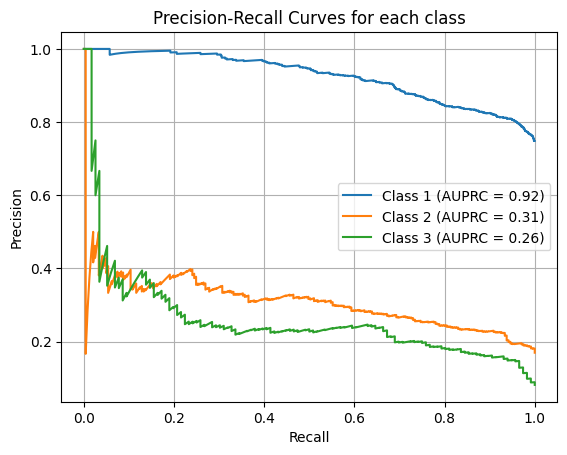


ROC Curves:


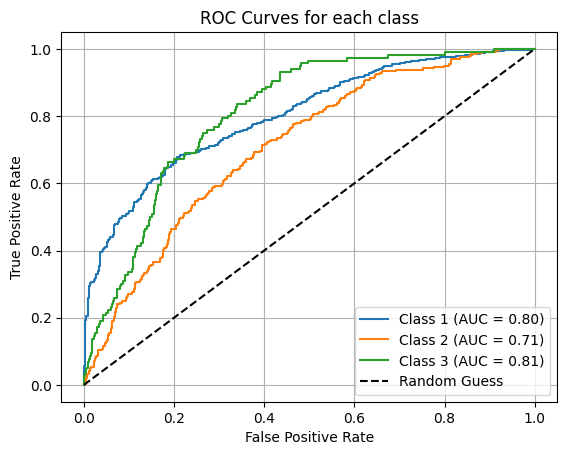


Mean F1 Score: 0.4747
Balanced Accuracy: 0.5122
Average AUPRC: 0.4957

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      1063
           1       0.32      0.35      0.33       241
           2       0.22      0.44      0.29       116

    accuracy                           0.65      1420
   macro avg       0.47      0.51      0.47      1420
weighted avg       0.72      0.65      0.68      1420

Accuracy for each fold: [np.float64(0.5477247677531097), np.float64(0.5172062222794288), np.float64(0.5701290275417147), np.float64(0.4982200140962285), np.float64(0.5121575605907792)]
AUPRC for each fold: [np.float64(0.5293730802115579), np.float64(0.5076717743103131), np.float64(0.5392148288471893), np.float64(0.48027358924213887), np.float64(0.4956764821709682)]
Average AUPRC across all folds: 0.5104419509564335
Average Balanced Accuracy across all folds: 0.5290875184522522
__________________________________________

In [9]:
import pandas as pd
import os
import datetime


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


top_params = top5 = [
    # Trial 39, accuracy: 0.6009
    {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 0.0001672579468577945, 'weight_decay': 1.8129496285151885e-05, 'num_transformer_blocks': 6, 'num_heads': 4},
    # Trial 129, accuracy: 0.6005
    {'n_patches': 14, 'embed_dim': 256, 'learning_rate': 1.2148194260197547e-05, 'weight_decay': 1.3849124915372121e-05, 'num_transformer_blocks': 4, 'num_heads': 8},
    # Trial 46, accuracy: 0.5833
    {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 8.304399003424909e-05, 'weight_decay': 1.10000875087108e-05, 'num_transformer_blocks': 8, 'num_heads': 4},
    # Trial 73, accuracy: 0.5806
    {'n_patches': 14, 'embed_dim': 256, 'learning_rate': 4.3271294952391774e-05, 'weight_decay': 1.4747298280634858e-05, 'num_transformer_blocks': 2, 'num_heads': 8},
    # Trial 130, accuracy: 0.5790
    {'n_patches': 14, 'embed_dim': 256, 'learning_rate': 1.8624174196030355e-05, 'weight_decay': 1.3861372035933134e-05, 'num_transformer_blocks': 4, 'num_heads': 8},
]


for param_id in range(len(top_params)):
    
    print(f"Running experiment with parameters: {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    # Fold indices and other configurations
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3

    epochs = 100
    input_shape = (3, 224,224)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    n_patches = top_params[param_id]['n_patches']
    hidden_size = top_params[param_id]['embed_dim']
    num_transformer_blocks = top_params[param_id]['num_transformer_blocks']
    weight_decay = top_params[param_id]['weight_decay']
    num_heads = top_params[param_id]['num_heads']
    learning_rate = top_params[param_id]['learning_rate']
    factor = 1
    batch_size = 16

   



    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = vit(
            input_size=input_shape, 
            n_patches=n_patches, 
            hidden_size=hidden_size, 
            num_classes=num_classes,
            num_transformer_blocks=num_transformer_blocks,
            num_heads=num_heads
        ).to(device)
        fold_model.to(device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')


    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    



In [ ]:
#clear gpu and restart kernel
torch.cuda.empty_cache()
#restart kernel
import gc
gc.collect()
# Restart the kernel to clear memory
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  # This will restart the kernel

{'status': 'ok', 'restart': True}

: 